In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import IBMQ, QuantumCircuit, transpile
from qiskit.circuit import Gate, Parameter
from qiskit.tools.monitor import job_monitor
from qiskit_experiments.database_service import DbExperimentDataV1 as DbExperimentData

from cross_resonance import LinearizedCR, PulseEfficientCR, DefaultRtt, cx_circuit
from calibrations import MeasurementErrorMitigation, MeasurementErrorExperiment, LinearizedCRRabiExperiment
from model_circuits import single_step_no_opt, single_step, two_steps
from dynamics import plot_counts_with_curve

In [2]:
IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q-research', group='tokyo-1', project='main')
#backend = provider.get_backend('ibm_lagos')
#physical_qubits = [1, 3, 5, 6]
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='icepp')
backend = provider.get_backend('ibmq_quito')
physical_qubits = [2, 1, 3, 4]

In [3]:
#exp = MeasurementErrorExperiment(physical_qubits, circuits_per_state=(backend.configuration().max_experiments // 16))
#exp_data = exp.run(backend=backend, shots=8192)
#print(exp_data.experiment_id)
#mem_experiment_id = exp_data.experiment_id
#exp_data.block_for_results()
#exp_data.save()

In [4]:
lcr_experiment_ids = dict()
for qubits in [physical_qubits[:2], physical_qubits[1:3], physical_qubits[2:]]:
    exp = LinearizedCRRabiExperiment(qubits, backend)
    exp.circuits_per_point = backend.configuration().max_experiments // exp.width_values.shape[0]
    exp_data = exp.run(backend=backend, shots=8192)
    print(exp_data.experiment_id)
    lcr_experiment_ids[tuple(qubits)] = exp_data.experiment_id
    exp_data.block_for_results()
    exp_data.save()
    
# ibmq_jakarta [1, 3, 5, 6]
#lcr_experiment_ids = {
#    (1, 3): '58a018c8-1029-4bbf-9ad1-a16e57220444',
#    (3, 5): 'd95780a6-120a-4df6-a63f-1049ee3b53bc',
#    (5, 6): 'b8648948-fb0a-408a-bdf8-c2a2a99684b7'
#}
#mem_experiment_id = '06530479-b302-4bab-92f9-2fa8229e99f9'

# ibmq_quito [2, 1, 3, 4]
#lcr_experiment_ids = {
#    (2, 1): '8b75a6fa-acfd-4c5f-a007-e01e0e8935b0',
#    (1, 3): '526741cb-15b8-435a-b96f-52fd473e5cc5',
#    (3, 4): '86c7660c-f1aa-4e90-bf69-83f8c5bb3764'
#}
#mem_experiment_id = '5195e012-c16b-46c7-8213-1e74e5e3303a'

8b75a6fa-acfd-4c5f-a007-e01e0e8935b0
526741cb-15b8-435a-b96f-52fd473e5cc5
86c7660c-f1aa-4e90-bf69-83f8c5bb3764


In [6]:
crs_linear = {
    (0, 1): LinearizedCR(backend, tuple(physical_qubits[:2])),
    (1, 2): LinearizedCR(backend, tuple(physical_qubits[1:3])),
    (2, 3): LinearizedCR(backend, tuple(physical_qubits[2:]))
}
crs_pe = {
    (0, 1): PulseEfficientCR(backend, tuple(physical_qubits[:2])),
    (1, 2): PulseEfficientCR(backend, tuple(physical_qubits[1:3])),
    (2, 3): PulseEfficientCR(backend, tuple(physical_qubits[2:]))
}
crs_default = dict((qubits, DefaultRtt()) for qubits in [(0, 1), (1, 2), (2, 3)])
for qubits, cr in crs_default.items():
    cr.native_direction = crs_linear[qubits].native_direction

cxs = {
    (0, 1): cx_circuit(backend, *tuple(physical_qubits[:2])),
    (1, 0): cx_circuit(backend, *tuple(physical_qubits[1::-1]))
}
mem = MeasurementErrorMitigation(backend, physical_qubits)

for lcr in crs_linear.values():
    if lcr.native_direction:
        qubits = (lcr.z_qubit, lcr.x_qubit)
    else:
        qubits = (lcr.x_qubit, lcr.z_qubit)

    lcr.load_calibration(lcr_experiment_ids[qubits])

mem.load_matrix(mem_experiment_id)

In [7]:
nsites = 4

J = 1. # Hamiltonian J parameter
mu = 0.5 # Hamiltonian mu parameter

M = 8 # number of Trotter steps
omegadt = 0.2 # Trotter step size

In [8]:
def combined_and_corrected_counts(job, exp_block_size):
    raw_counts = job.result().get_counts()
    counts = raw_counts[:exp_block_size]
    for iexp, cdict in enumerate(raw_counts[exp_block_size:]):
        ic = iexp % exp_block_size
        for key, value in cdict.items():
            try:
                counts[ic][key] += value
            except KeyError:
                counts[ic][key] = value

    return mem.apply(counts)

## Forward steps with LinearizedCR

In [9]:
single_step_circuit = single_step(J, mu, omegadt, crs=crs_linear, cxs=cxs)
two_step_circuit = two_steps(J, mu, omegadt, crs=crs_linear, cxs=cxs)

circuits = []
for nrep in range(1, M + 1):
    circuit = QuantumCircuit(nsites, nsites)
    circuit.x(1)
    circuit.x(3)
    for _ in range(nrep // 2):
        circuit.compose(two_step_circuit, inplace=True)
    if nrep % 2 == 1:
        circuit.compose(single_step_circuit, inplace=True)
    circuit.measure(circuit.qregs[0], circuit.cregs[0])
    circuits.append(circuit)
    
circuits = transpile(circuits, backend=backend, initial_layout=physical_qubits, optimization_level=1)
circuits *= backend.configuration().max_experiments // M

In [10]:
job = backend.run(circuits, shots=8192)
print(job.job_id())
job_monitor(job)
#job = backend.retrieve_job('6161bdadc978664b30093020')

6164f444fb30d2081f825180
Job Status: job has successfully run


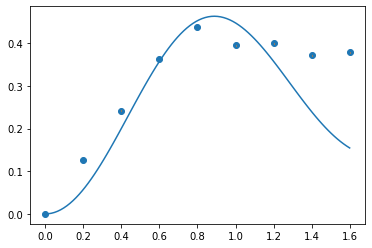

In [11]:
plot_counts_with_curve(combined_and_corrected_counts(job, M), nsites, J, mu, omegadt, M)

## Forward steps with Pulse-Efficient CR

In [12]:
single_step_circuit = single_step(J, mu, omegadt, crs=crs_pe, cxs=cxs)
two_step_circuit = two_steps(J, mu, omegadt, crs=crs_pe, cxs=cxs)

circuits = []
for nrep in range(1, M + 1):
    circuit = QuantumCircuit(nsites, nsites)
    circuit.x(1)
    circuit.x(3)
    for _ in range(nrep // 2):
        circuit.compose(two_step_circuit, inplace=True)
    if nrep % 2 == 1:
        circuit.compose(single_step_circuit, inplace=True)
    circuit.measure(circuit.qregs[0], circuit.cregs[0])
    circuits.append(circuit)
    
circuits = transpile(circuits, backend=backend, initial_layout=physical_qubits, optimization_level=1)
circuits *= backend.configuration().max_experiments // M

In [13]:
job = backend.run(circuits, shots=8192)
print(job.job_id())
job_monitor(job)
#job = backend.retrieve_job('6161cc37ed29dd246fc6826e')

6164f51ba4f5339b050e85e8
Job Status: job has successfully run


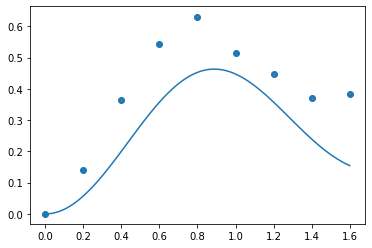

In [14]:
plot_counts_with_curve(combined_and_corrected_counts(job, M), nsites, J, mu, omegadt, M)

## Forward with naive implementation (optimization level 3)

In [15]:
single_step_circuit = single_step_no_opt(J, mu, omegadt)

circuits = []
for nrep in range(1, M + 1):
    circuit = QuantumCircuit(nsites, nsites)
    circuit.x(1)
    circuit.x(3)
    for _ in range(nrep):
        circuit.compose(single_step_circuit, inplace=True)
    circuit.measure(circuit.qregs[0], circuit.cregs[0])
    circuits.append(circuit)
    
circuits = transpile(circuits, backend=backend, initial_layout=physical_qubits, optimization_level=3)
circuits *= backend.configuration().max_experiments // M

In [16]:
job = backend.run(circuits, shots=8192)
print(job.job_id())
job_monitor(job)
#job = backend.retrieve_job('616213fcc97866743e0931d4')

6164f5f3ce0f4f3608f26344
Job Status: job has successfully run


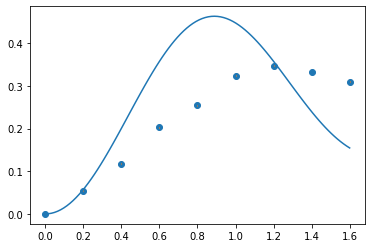

In [17]:
plot_counts_with_curve(combined_and_corrected_counts(job, M), nsites, J, mu, omegadt, M)

## Forward steps with CNOT-based Rtt

In [18]:
single_step_circuit = single_step(J, mu, omegadt, crs=crs_default)
two_step_circuit = two_steps(J, mu, omegadt, crs=crs_default)

circuits = []
for nrep in range(1, M + 1):
    circuit = QuantumCircuit(nsites, nsites)
    circuit.x(1)
    circuit.x(3)
    for _ in range(nrep // 2):
        circuit.compose(two_step_circuit, inplace=True)
    if nrep % 2 == 1:
        circuit.compose(single_step_circuit, inplace=True)
    circuit.measure(circuit.qregs[0], circuit.cregs[0])
    circuits.append(circuit)
    
circuits = transpile(circuits, backend=backend, initial_layout=physical_qubits, optimization_level=1)
circuits *= backend.configuration().max_experiments // M

In [19]:
job = backend.run(circuits, shots=8192)
print(job.job_id())
job_monitor(job)
#job = backend.retrieve_job('6161cc37ed29dd246fc6826e')

6164f6d3fb30d274188251a3
Job Status: job has successfully run


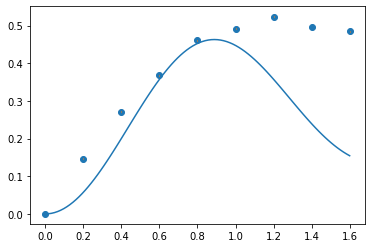

In [20]:
plot_counts_with_curve(combined_and_corrected_counts(job, M), nsites, J, mu, omegadt, M)